In [ ]:
!pip install clearml

     |████████████████████████████████| 1.0 MB 28.1 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 


In [ ]:
%%bash

export api=`cat <<EOF
api {
    # Stef Telford's workspace
    web_server: https://app.community.clear.ml
    api_server: https://api.community.clear.ml
    files_server: https://files.community.clear.ml
    credentials {
        "access_key" = "P3HU9EH0MOMZ4Z8WUNT0"
        "secret_key" = "7EaR8xZoHSKNm3HGzcHhCwcWnulmmmDOtLzj0WICVtwXbw5fYZ"
    }
}
EOF
`
echo "$api" > /root/clearml.conf

In [ ]:
from clearml import Task
task = Task.init(project_name="SemanticSeg_with_ShareTrainValTest", task_name="my task")

ClearML Task: created new task id=ea519e6fb1bd48a496cd9c352c49e62c
ClearML results page: https://app.community.clear.ml/projects/0cb82eeeedb144e687f76d2147d127fc/experiments/ea519e6fb1bd48a496cd9c352c49e62c/output/log


In [1]:
from numpy.random import seed
seed(123)
from tensorflow.random import set_seed
set_seed(123)

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dropout,MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Sequential
import os,datetime



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
import random
# Input data files are available in the "../input/" directory.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
print(os.listdir('/content/gdrive/MyDrive/Colab_Notebooks/Semantic_Segmentation/Semantic_Segmentation/dataA/dataA'))

In [ ]:
from glob import  glob
image_path = glob('/content/gdrive/MyDrive/Colab_Notebooks/Semantic_Segmentation/Semantic_Segmentation/*/*/CameraRGB/*')
mask_path = glob('/content/gdrive/MyDrive/Colab_Notebooks/Semantic_Segmentation/Semantic_Segmentation/*/*/CameraSeg/*')
image_link = [i for i in image_path]
mask_link = [i for i in mask_path]
images = [cv2.imread(image_link[i]) for i in range(len(image_link))]
plt.imshow(image_link[1])

Text(0.5, 1.0, 'Segmentation')

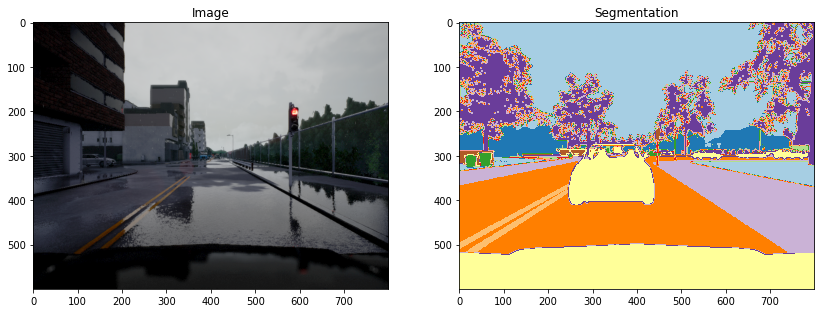

In [ ]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

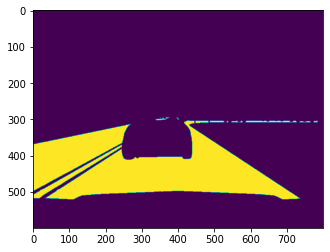

In [ ]:
road = np.zeros((600,800))
road[np.where(mask == 7)[0], np.where(mask == 7)[1]]=1
plt.imshow(road)

In [ ]:
from tqdm import tqdm

height, width = 512, 512
dim = (width, height)
images = np.zeros((len(image_list), height, width, 3), dtype=np.int16)
masks = np.zeros((len(image_list), height, width, 1), dtype=np.int8)

for n in tqdm(range(len(image_list))):
    img = imageio.imread(image_list[n])
    
    mask = imageio.imread(mask_list[n])
    mask=  cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
    mask_road = np.zeros((height, width, 1), dtype=np.int8)
    mask_road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
    
    images[n] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    masks[n] = mask_road

100%|██████████| 1000/1000 [10:16<00:00,  1.62it/s]


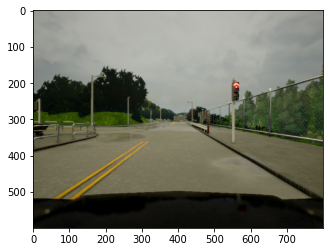

In [ ]:
np.where(mask==7)[0]
plt.imshow(img)

In [ ]:
np.random.seed(123)
shuffle_ids = np.array([i for i in range(len(masks))])
np.random.shuffle(shuffle_ids)
train_ids = shuffle_ids[:int(len(masks)*0.8)]
val_ids = shuffle_ids[int(len(masks)*0.8):int(len(masks)*0.8+100)]
test_ids = shuffle_ids[int(len(masks)*0.8+100):]

In [ ]:
train_images, train_masks = images[train_ids], masks[train_ids]
val_images, val_masks = images[val_ids], masks[val_ids]
test_images, test_masks = images[test_ids], masks[test_ids]

In [ ]:
train_images.shape, val_images.shape, test_images.shape

((800, 512, 512, 3), (100, 512, 512, 3), (100, 512, 512, 3))

In [ ]:
# Build U-Net model
input_img = tf.keras.layers.Input((height, width, 3), name='img')

c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(input_img)
c1=Dropout(0.1)(c1)
c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1=MaxPooling2D(2,2)(c1)

c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(p1)
c2=Dropout(0.1)(c2)
c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c2)
p2=MaxPooling2D(2,2)(c2)

c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(p2)
c3=Dropout(0.1)(c3)
c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c3)
p3=MaxPooling2D(2,2)(c3)

c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(p3)
c4=Dropout(0.1)(c4)
c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c4)
p4=MaxPooling2D(2,2)(c4)

c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(p4)
c5=Dropout(0.2)(c5)
c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c5)
#p1=MaxPooling2D(2,2)(c1)


#Expansive path
u6=Conv2DTranspose(128,(3,3),activation='relu',strides=(2,2),kernel_initializer='he_normal', padding='same')(c5)
u6=concatenate([u6,c4])
c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(u6)
c6=Dropout(0.2)(c6)
c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c6)

u7=Conv2DTranspose(64,(3,3),activation='relu',strides=(2,2),kernel_initializer='he_normal', padding='same')(c6)
u7=concatenate([u7,c3])
c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(u7)
c7=Dropout(0.2)(c7)
c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c7)

u8=Conv2DTranspose(32,(3,3),activation='relu',strides=(2,2),kernel_initializer='he_normal', padding='same')(c7)
u8=concatenate([u8,c2])
c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(u8)
c8=Dropout(0.1)(c8)
c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c8)

u9=Conv2DTranspose(16,(3,3),activation='relu',strides=(2,2),kernel_initializer='he_normal', padding='same')(c8)
u9=concatenate([u9,c1])
c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(u9)
c9=Dropout(0.1)(c9)
c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c9)


outputs=Conv2D(1,(1,1),activation='sigmoid')(c9)

model=tf.keras.Model(inputs=[input_img],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
c1.shape,p1.shape,c2.shape,p2.shape,c3.shape,p3.shape,c4.shape,p4.shape

(TensorShape([None, 512, 512, 16]),
 TensorShape([None, 256, 256, 16]),
 TensorShape([None, 256, 256, 32]),
 TensorShape([None, 128, 128, 32]),
 TensorShape([None, 128, 128, 64]),
 TensorShape([None, 64, 64, 64]),
 TensorShape([None, 64, 64, 128]),
 TensorShape([None, 32, 32, 128]))

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_nuclei_h5',verbose=1,save_best_only=True)
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
           tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)]

results = model.fit(train_images, train_masks, batch_size=16, epochs=10, callbacks=callbacks,
                    validation_data=(val_images, val_masks))

Epoch 1/10
 8/50 [===>..........................] - ETA: 27:35 - loss: 0.2050 - accuracy: 0.9473

In [ ]:
model.save('final-road-seg-model-v1.h5')

NameError: ignored

In [ ]:
NUMBER = 10
my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(height, width))
ax[0].set_title('Prediction')
ax[1].imshow(test_masks[NUMBER].reshape(height, width))
ax[1].set_title('Ground truth')